In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math
import plotly.express as px
import pandas as pd
import numpy as np

## 1. Load the Karate Graph from NetworkX

In [2]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Available nodes:", list(graph.nodes))
    print("Available edges:", list(graph.edges))
    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(directed_graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))

In [3]:
# built-in graph from networkx
karate_graph = nx.karate_club_graph()
get_graph_info(karate_graph)

Number of nodes: 34
Number of edges: 78
Available nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Available edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
Connected components: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

In [4]:
# club color reference
nation_color_dict = {
    'Mr. Hi': '#aff8df',
    'Officer': '#ffcbc1'
}

# function to assign color for node visualization
def create_node_colors_from_graph(graph, club_color_dict):
    node_colors = []
    for node, club in list(graph.nodes(data="club")):
        if club in club_color_dict:
            node_colors.append(club_color_dict[club])
    return node_colors

# get node colors for plotting
node_colors = create_node_colors_from_graph(karate_graph, nation_color_dict)

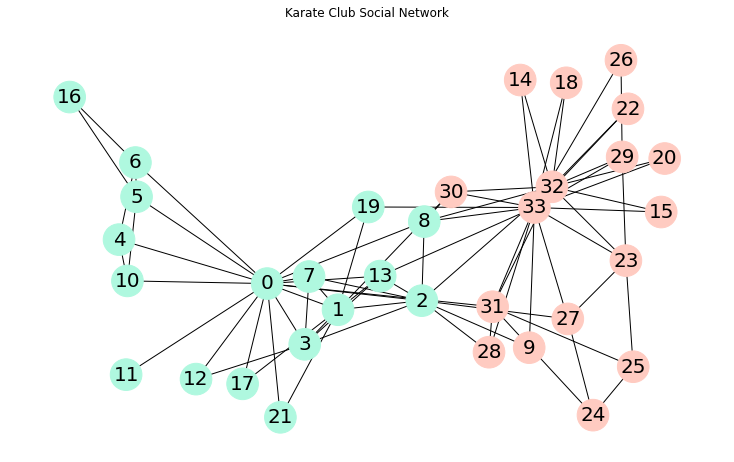

In [5]:
# create visualization
pos = nx.spring_layout(karate_graph, 
                       k=0.3, iterations=50,
                       seed=2)

plt.figure(1,figsize=(10,6)) 
nx.draw(karate_graph,
        pos = pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=True,
        font_size = 20,
        font_color='black')
plt.title("Karate Club Social Network")
plt.show()

### Mint color nodes are from the "Mr. Hi" Karate club and the Salmon color nodes are from the "Officer" Karate club. 

## Community Detection

### 2.0 Modularity:

* Modularity is widely used as a measure for how good a clustering is.  
* Modularity compares the number of edges inside a cluster with the expected number of edges that one would find in the cluster.
* A good modularity score falls within 0.3-0.7. 
* When modularity is close to 1, it indicates strong community structure. 
* When modularity is 0, it indicates the community division is worse than random.

Modularity suffers a resolution limit and, therefore, it is unable to detect small communities.


1. Definition: 
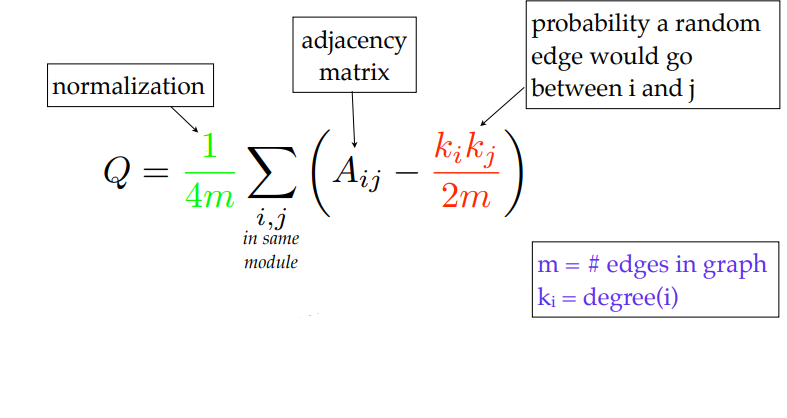

In [6]:
# function to return a node's neighbor nodes as a list
def get_neighbors(graph, node):
    return [n for n in graph.neighbors(node)]

In [7]:
# function to return the subgraph containing 2 nodes' common neighbors
def get_common_neighbor_subgraph(graph, source, target):
    nodes = [source, target] + list(nx.common_neighbors(karate_graph, source, target))
    return graph.subgraph(nodes)

### 2.1 Girvan-Newman:

1. Definition:
    * Detects communities by progressively removing edges from the original graph. 
    * The algorithm removes the "most valuable" edge, traditionally the edge with the highest betweenness centrality, at each step. 
    * As the graph breaks down into pieces, the tightly knit community structure is exposed and the result can be depicted as a dendrogram.
    
2. How to:  
    Step 1: For every edge in a graph, calculate the edge betweenness centrality.  
    Step 2: Remove the edge with the highest betweenness centrality.  
    Step 3: Calculate the betweenness centrality again for every remaining edge.  
    Step 4: Repeat steps 2-3 until there are no more edges left.  

In [8]:
from networkx.algorithms.community.centrality import girvan_newman
import networkx.algorithms.community as nx_comm

In [9]:
# find communities
girvan_newman_communities = list(girvan_newman(karate_graph))

### let's study how does modularity changes as important edges been removed

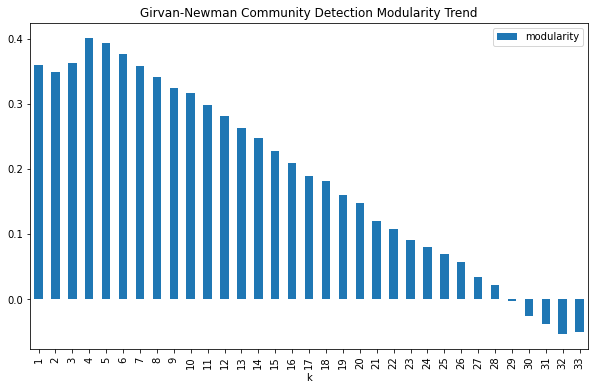

In [12]:
modularity_df = pd.DataFrame([[k+1, round(nx_comm.modularity(karate_graph, girvan_newman_communities[k]), 6)]
                for k in range(len(girvan_newman_communities))],
                            columns=["k", "modularity"])
modularity_df.plot.bar(x="k", figsize=(10,6), title="Girvan-Newman Community Detection Modularity Trend");

### From the above choice of K, we can observe the modularity decreases as k increases. It implies weaker community structure as more edges being removed and more cluster being formed. 

In [13]:
# function create node color list for less than 7 communities
# when there are more than 6 colors, visualization can be confusing for human
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

In [14]:
def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

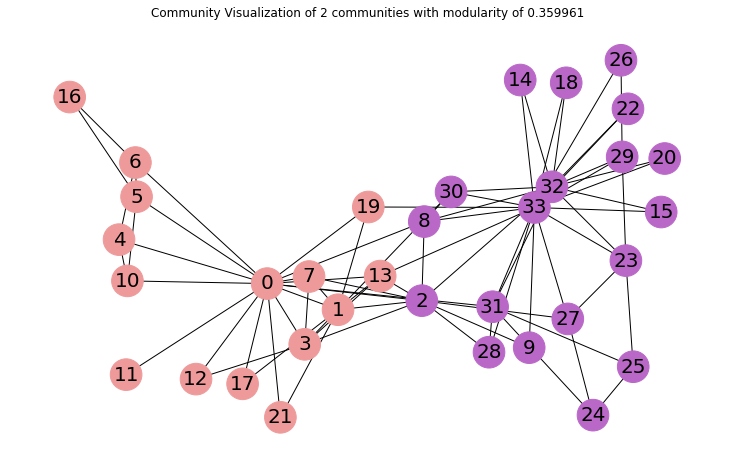

In [15]:
visualize_communities(karate_graph, girvan_newman_communities[0])

### K = 4 has the highest modularity score. Let's take a look at how Girvan-Newman algorithm partitions the network with 4 edges removed. 

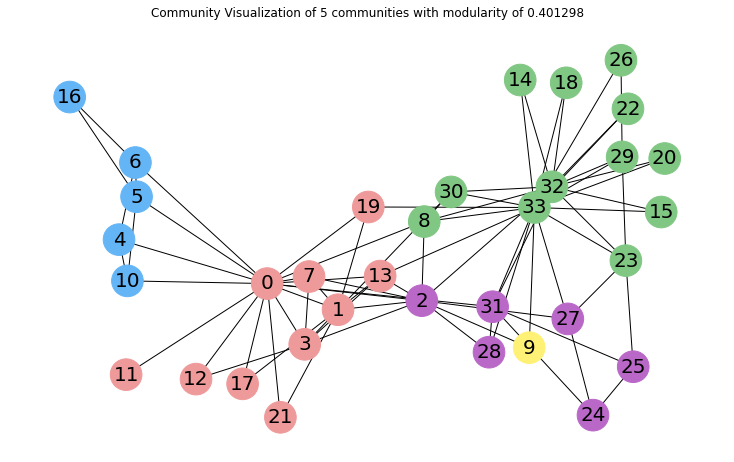

In [16]:
visualize_communities(karate_graph, girvan_newman_communities[3])

### After 4th iteration, the above visualization is the final partitions of graph based on removing the edge with highest betweenness centrality at each iteration. 

### 2.2 Label Propagation:

0. Assumption: an edge connecting two nodes carry a notion of similarity.
1. Definition: generate community labels by propagating through the network based on highest frequent label.
    
2. How to:  
    Step 1: After initializing each node with a unique label, the algorithm repeatedly sets the label of a node to be the label that appears most frequently among that node's neighbors.  
    Step 2: The algorithm halts when each node has the label that appears most frequently among its neighbors. The algorithm is asynchronous because each node is updated without waiting for updates on the remaining nodes.
    
Disadvantages:
1. Random initialization can result partitions with no unique solution, but NetworkX implementation has a fixed random state so that the output will be reproducible.

In [17]:
from networkx.algorithms.community.label_propagation import label_propagation_communities

In [18]:
# find communities
label_prop_communities = list(label_propagation_communities(karate_graph))
label_prop_communities

[{0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30, 32, 33},
 {5, 6, 16}]

### Unlike Girvan-Newman, you can't control how many communities or iterations. We obtained 3 communities identified by the label propagation community detection algorithm. Let's visualize it with my functiond defined earlier.

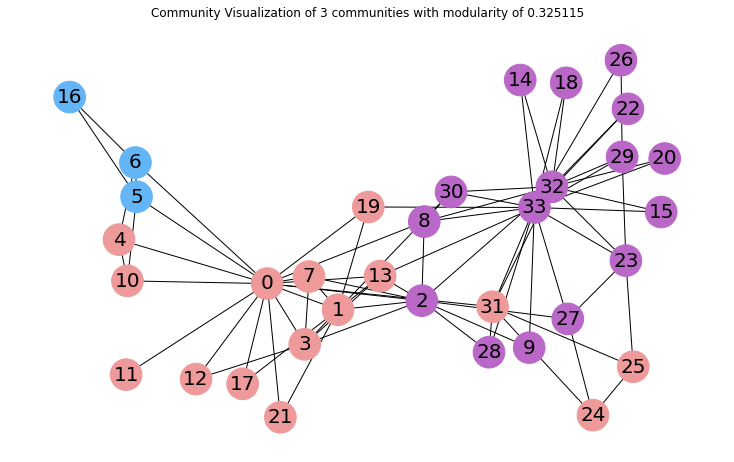

In [19]:
visualize_communities(karate_graph, label_prop_communities)

### The modularity of the current partition is 0.325115, which is not bad > 0.3 and < 0.7. Let's visualize the subgraphs based on the communities partitioned.

In [20]:
def visualize_subgraph(graph, subgraph_nodes, node_color):
    # get subgraph
    subgraph = nx.subgraph(graph, subgraph_nodes)

    # create visualization
    node_colors = [node_color] * len(subgraph_nodes)
    title = f"Community Partition Subgraph"
    pos = nx.spring_layout(subgraph, 
                           k=0.3, iterations=50,
                           seed=2)

    plt.figure(1,figsize=(8,6)) 
    nx.draw(subgraph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

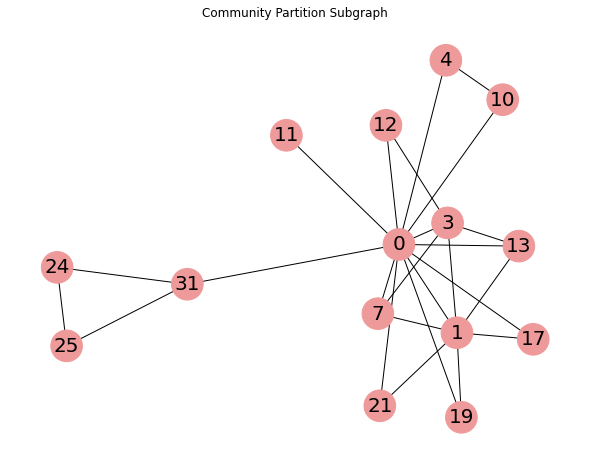

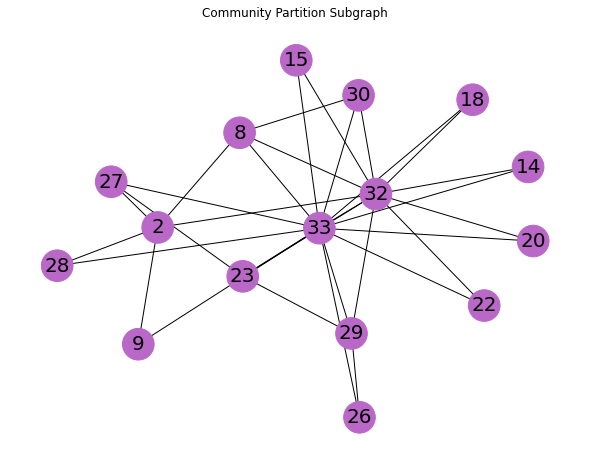

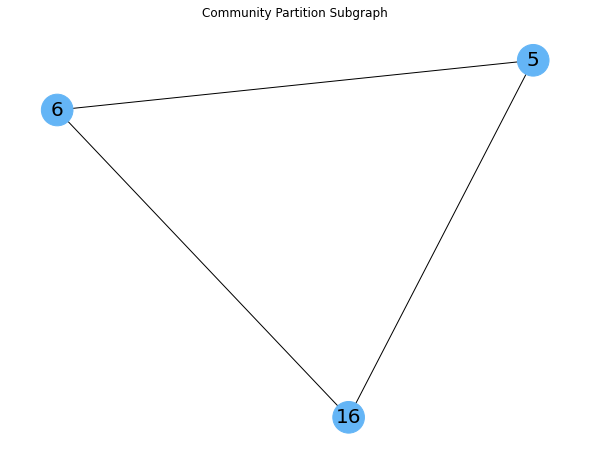

In [21]:
colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784", "#FFF176", "#BDBDBD"]
for i in range(len(label_prop_communities)):
    visualize_subgraph(karate_graph, label_prop_communities[i], colors[i])

### After plotting the subgraph, we can see the partitions better. Interestingly, the 2nd purple subgraph is actually an triangle and it's originally located on the top left of the network visualization.

### 2.3 Louvain:

1. Definition: a community detection algorithm based on optimization of modularity
    
* **Modularity Gain**:
Then for each node i, the change in modularity is calculated for removing i from its own community and moving it into the community of each neighbor j of i. This value is easily calculated by two steps: 
(1) removing i from its original community, and 
(2) inserting i to the community of j. The two equations are quite similar.
Read more here: https://en.wikipedia.org/wiki/Louvain_method
    
2. How to:  
   * **Initialization**: each node in the network is assigned to its own community.  
   * **Phase 1 Local moving of nodes**: iterates all the nodes and experiment with adding single node to other communities to maximize the modularity gain until no modularity gain can be improved. Once this local maximum of modularity is hit, the first phase has ended.  
   * **Phase 2 Aggregation of the network**: groups all of the nodes in the same community and builds a new network where nodes are the communities from the previous phase. Any links between nodes of the same community are now represented by self-loops on the new community node and links from multiple nodes in the same community to a node in a different community are represented by weighted edges between communities. Once the new network is created, the second phase has ended and the first phase can be re-applied to the new network.
 
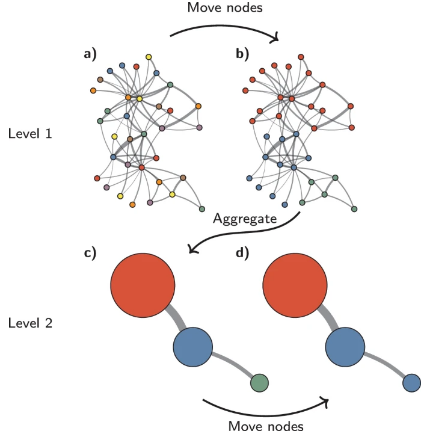

**Advantages**:
1. Fast in O(nlogn) time
2. Louvain provides two guarantees: no communities can be merged & no nodes can be moved.

**Disadvantages**:
1. Use of storage of the network in the main memory.
2. Louvain algorithm does not guarantee connectivity
3. Tendency to discover communities that are internally disconnected (badly connected communities)
4. Doesn’t guarantee well-connected communities
5. Louvain has no mechanism for fixing badly connected communities.
6. DIstribution of the badly connected communities will not improve overtime


In [22]:
import community as community_louvain

In [47]:
# convert the python-louvain package output to 
# NetworkX package community function output format
def get_louvain_communities(graph, random_state=1):
    louvain_partition_dict = community_louvain.best_partition(graph, random_state=random_state)
    unique_partition_labels = list(set(louvain_partition_dict.values()))
    communities = [[] for i in range(len(unique_partition_labels))]
    for node in louvain_partition_dict.keys():
        communities[louvain_partition_dict[node]].append(node)
    return communities

In [48]:
# get communities using louvain algorithm
louvain_communities = get_louvain_communities(karate_graph, random_state=1)
louvain_communities

[[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [23, 24, 25, 27, 28, 31],
 [4, 5, 6, 10, 16],
 [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]]

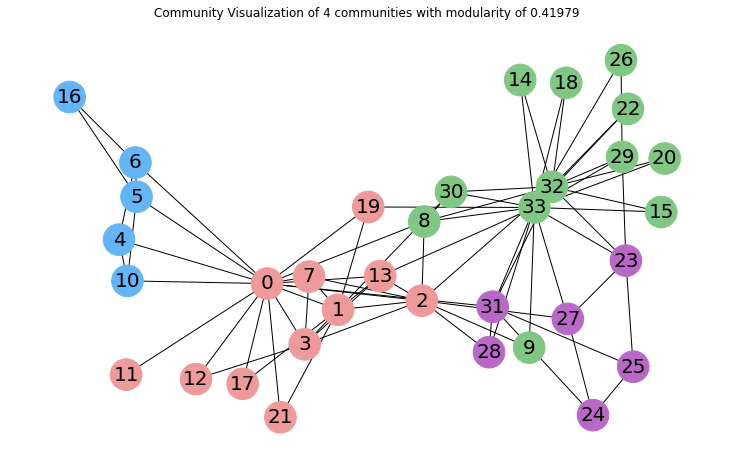

In [49]:
visualize_communities(karate_graph, louvain_communities)

### Louvain algoirithm obtained the highest modularity score of 0.41979. Both Louvain and Label Propagation categorized node 9 into a larger group whereas Girvan-Newman algorithm sparated the node 9 because the iterative nature of removing highest edge centrality edge for each K iterations. Let's visualize the subgraphs for the communities.

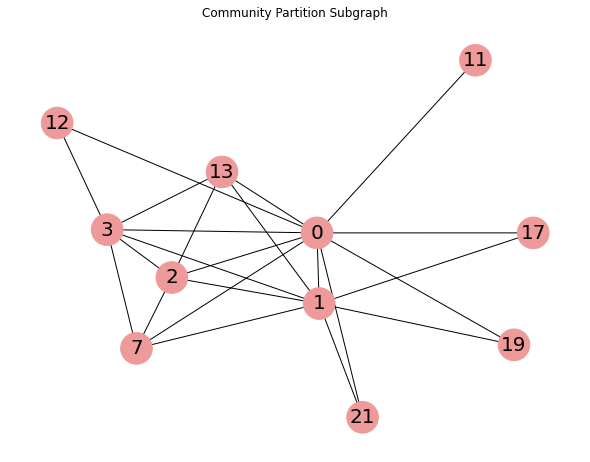

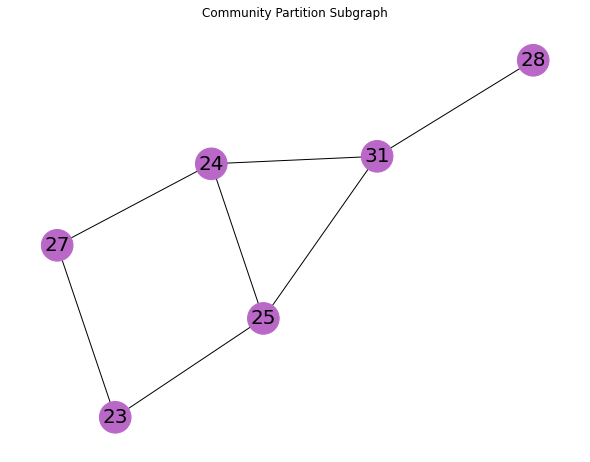

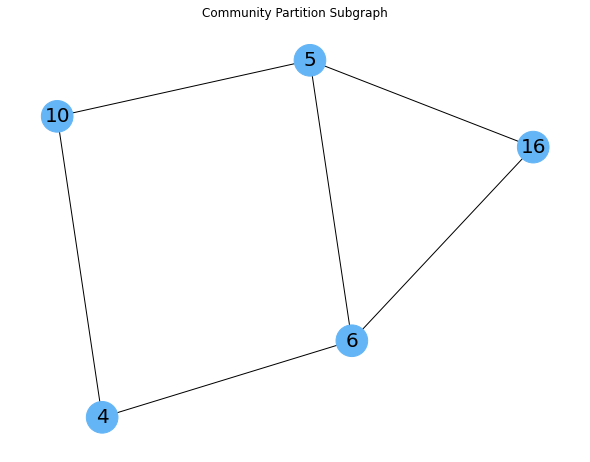

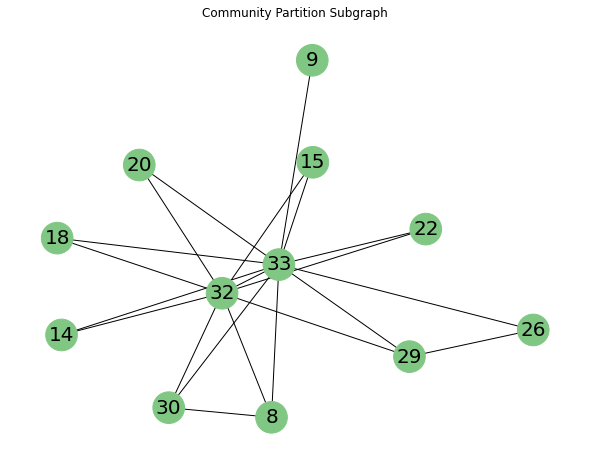

In [50]:
colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784", "#FFF176", "#BDBDBD"]
for i in range(len(louvain_communities)):
    visualize_subgraph(karate_graph, louvain_communities[i], colors[i])